**IMPORTS:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tsfm
import torchvision.utils

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL.ImageOps


**Downloading data:**

In [3]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2022-08-19 08:42:50--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2022-08-19 08:42:51--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.1’

at&t.zip.1          100%[===================>]   3.62M  --.-KB/s    in 0.02s   

2022-08-19 08:42:54 (199 MB/s) - ‘at&t.zip.1’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   crea

**Custom Dataset Class:**

Accepts 2 image inputs and 1 label

If two images are of the same person, Label = 0

else, Label = 1

In [4]:
class SNdataset(Dataset):

  def __init__(self, imageFolderDataset, transform=None):
    self.imageFolderDataset=imageFolderDataset
    self.transform=transform

  def __getitem__(self, index):
    img_tuple0=random.choice(self.imageFolderDataset.imgs) #get imgs randomly

    #to get 50% of imgs into the same class

    same_class=random.randint(0,1)

    if same_class:
      while True:

        img_tuple1=random.choice(self.imageFolderDataset.imgs) #look till same class img is found
        if img_tuple0[1] == img_tuple1[1]:
          break

    else:
      while True:

        img_tuple1=random.choice(self.imageFolderDataset.imgs) #else look till diff img class is found
        if img_tuple0[1] != img_tuple1[1]:
          break

    img0=Image.open(img_tuple0[0])
    img1=Image.open(img_tuple1[0])

    #greyscale

    img0=img0.convert("L")
    img1=img1.convert("L")

    if self.transform is not None:

      img0=self.transform(img0)
      img1=self.transform(img1)

    return img0, img1, torch.from_numpy(np.array([int(img_tuple1[1] != img_tuple0[1])], dtype=np.float32))
      
  def __len__(self):
    return len(self.imageFolderDataset.imgs)

**Loading Dataset:**

In [5]:
path=datasets.ImageFolder(root="/content/data/faces/training")

In [6]:
transformer=tsfm.Compose([
                             tsfm.Resize((100,100)),
                             tsfm.ToTensor()
                         ])

#intialize:
input_dataset=SNdataset(imageFolderDataset=path,transform=transformer)

**DataLoader for Visualization:**

In [7]:
#functions for displaying data and plotting loss fn

def imshow(img):

  npimg=img.numpy()
  plt.axis("off")

  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

def plot_loss(iterationNum, loss):
  plt.plot(iterationNum, loss)
  plt.show()  


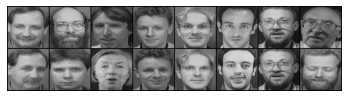

[0. 1. 1. 0. 0. 0. 0. 1.]


In [38]:
visualizer=DataLoader(input_dataset, shuffle=True, num_workers=2, batch_size=8)

batch1=next(iter(visualizer))

group=torch.cat((batch1[0],batch1[1]),0)

imshow(torchvision.utils.make_grid(group)) # dataset

print(batch1[2].numpy().reshape(-1)) #prints the classes

# 0 - same class(person)
# 1 - different class

**SIAMESE NN CLASS:**

In [44]:
class SN(nn.Module):

    def __init__(self):
        super(SN, self).__init__()

        #CNN

        self.cnn= nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

        #FCL

        self.fc= nn.Sequential(
            
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256,2)
        )


    def innerForward(self, x): #Actual forward function
        
        output= self.cnn(x)
        output= output.view(output.size()[0], -1)
        output= self.fc(output)

        return output

    def forward(self, inp1, inp2):    #calls forward pass for the 2 images and returns output vectors

        out1= self.innerForward(inp1)
        out2= self.innerForward(inp2)

        return out1, out2  


**CONTRASTIVE LOSS FUNCTION:**

In [45]:
class clf(torch.nn.Module):

  def __init__(self, margin=2.0): #margin for cl has beet set 2, can be decreased for fine tuning

    super(clf, self).__init__()
    self.margin=margin

  def forward(self, out1, out2, label):

    euclidean_distance=F.pairwise_distance(out1, out2, keepdim=True) #L2 Norm between two output vectors

    cl=torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) #combination of L2 and Hinge Loss

    return cl


**DataLoader:**

In [46]:
train_dl=DataLoader(input_dataset, shuffle=True, num_workers=8, batch_size=64)

sn=SN().cuda()

criterion=clf()

optimizer=optim.Adam(sn.parameters(), lr=0.0003)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**TRAIN:**

In [47]:
counter=[]
loss_hist=[]
iter_num=0


for epoch in range(100):

  for i, (img0, img1, label) in enumerate(train_dl,0): #iterating through batches-64

    img0, img1, label=img0.cuda(), img1.cuda(), label.cuda()

    optimizer.zero_grad() #zero grad

    out1, out2=sn(img0, img1) #pass input data to sn

    cl=criterion(out1, out2, label) #calculate loss with output vectors

    cl.backward() #backward propagation

    optimizer.step()

    #printing out loss for every 10 batches:

    if i%10==0:

      print(f"Epoch number: {epoch}\nCurrent loss: {cl.item()}\n")

      iter_num+=10

      counter.append(iter_num)
      loss_hist.append(cl.item())

Epoch number: 0
Current loss: 2.309525966644287

Epoch number: 1
Current loss: 1.5809757709503174

Epoch number: 2
Current loss: 0.6448513269424438

Epoch number: 3
Current loss: 0.9188740849494934

Epoch number: 4
Current loss: 0.8743181228637695

Epoch number: 5
Current loss: 0.8925043344497681

Epoch number: 6
Current loss: 0.47408974170684814

Epoch number: 7
Current loss: 0.31478947401046753

Epoch number: 8
Current loss: 0.47183409333229065

Epoch number: 9
Current loss: 0.5479808449745178

Epoch number: 10
Current loss: 0.641400933265686

Epoch number: 11
Current loss: 0.46660512685775757

Epoch number: 12
Current loss: 0.3480585217475891

Epoch number: 13
Current loss: 0.3619365096092224

Epoch number: 14
Current loss: 0.2456737458705902

Epoch number: 15
Current loss: 0.4417891800403595

Epoch number: 16
Current loss: 0.5784662961959839

Epoch number: 17
Current loss: 0.6303292512893677

Epoch number: 18
Current loss: 0.47946083545684814

Epoch number: 19
Current loss: 0.43407

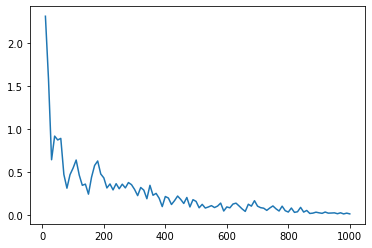

In [48]:
plot_loss(counter, loss_hist)

**TESTING:**

In [51]:
testPath = datasets.ImageFolder(root="/content/data/faces/testing")

test_dataset = SNdataset(imageFolderDataset=testPath,transform=transformer)

test_dl = DataLoader(test_dataset, num_workers=1, batch_size=1, shuffle=True)

**Displaying Variance [Dissimilarity]:**

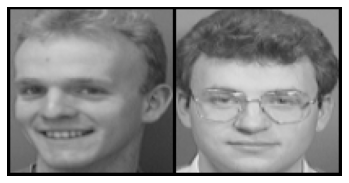

Variance= 2.790426


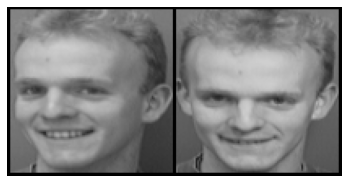

Variance= 0.889649


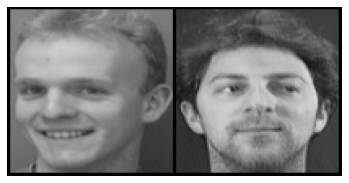

Variance= 4.177187


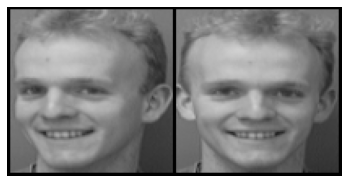

Variance= 0.551906


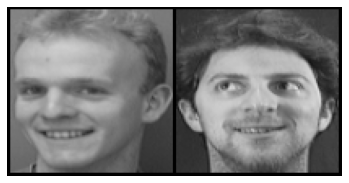

Variance= 4.201351


In [52]:
itered = iter(test_dl)
im1, _, _ = next(itered) #get the first img for comparison

for i in range(5):

    _, im2, label2 = next(itered)  #getting the next 5 images(im2) to be compared with first img1

    combi = torch.cat((im1, im2), 0)
    
    Tout1, Tout2 = sn(im1.cuda(), im2.cuda()) #SNN

    euclidean_distance = F.pairwise_distance(Tout1, Tout2) #loss fn

    #cl=torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(2.0 - euclidean_distance, min=0.0), 2))

    imshow(torchvision.utils.make_grid(combi))
    
    variance=euclidean_distance.item()

    print("Variance=","%2f" % variance)